# FACE ALIGNMENT SYSTEM DESIGN

## 1. Importing Libraries

In [1]:
# fundamental libs
import numpy as np
import cv2
import matplotlib.pyplot as plt

# alternative techniques:
from skimage.feature import hog
import cv2.xfeatures2d as cv_xfeatures2d
# conda install -c conda-forge opencv-python

c:\Users\HP\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 2. Data Loading and Preprocessing

In [2]:
# Load the data using np.load
data = np.load('training_images_full.npz', allow_pickle=True)

# Extract the images
images = data['images']
# and the data points
pts = data['points']

print(images.shape, pts.shape)

# Load the data that only has a subset of annotations using np.load
data = np.load('training_images_subset.npz', allow_pickle=True)

# Extract the images
images_subset = data['images']
# and the data points
pts_subset = data['points']

print(images_subset.shape, pts_subset.shape)

test_data = np.load('test_images.npz', allow_pickle=True)
test_images = test_data['images']
print(test_images.shape)

example_data = np.load('examples.npz', allow_pickle=True)
example_images = example_data['images']
print(example_images.shape)

(1425, 256, 256, 3) (1425, 44, 2)
(1386, 256, 256, 3) (1386, 5, 2)
(554, 256, 256, 3)
(6, 256, 256, 3)


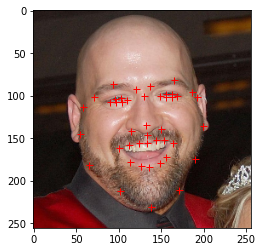

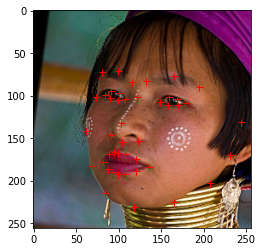

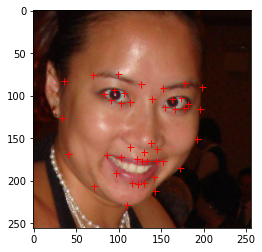

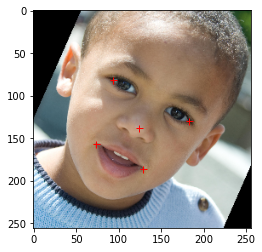

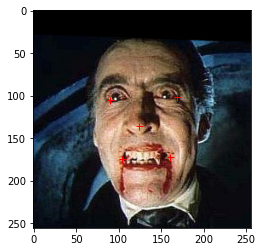

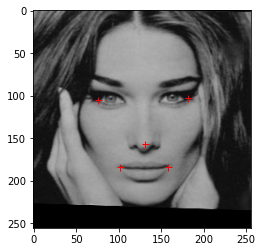

In [3]:
def visualise_pts(img, pts, title=None):
    import matplotlib.pyplot as plt
    plt.imshow(img)
    plt.plot(pts[:, 0], pts[:, 1], '+r', ms=7)
    if title:
        plt.title(title)
    plt.show()


for i in range(3):
  idx = np.random.randint(0, images.shape[0])
  visualise_pts(images[idx, ...], pts[idx, ...])

for i in range(3):
  idx = np.random.randint(0, images.shape[0])
  visualise_pts(images_subset[idx, ...], pts_subset[idx, ...])

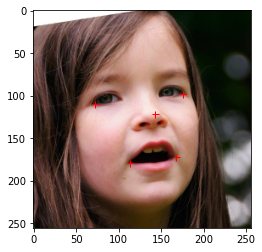

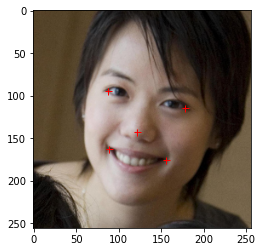

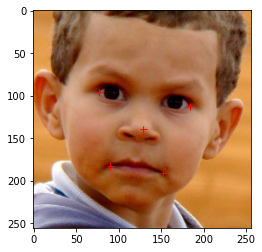

In [4]:
def extract_subset_of_points(pts):
  indices = (20, 29, 16, 32, 38)
  if len(pts.shape) == 3:
    return pts[:, indices, :]
  elif len(pts.shape) == 2:
    return pts[indices, :]


for i in range(3):
  idx = np.random.randint(0, images.shape[0])
  visualise_pts(images[idx, ...], extract_subset_of_points(pts[idx, ...]))

## 3. Function Definitions for Further Pre-processing and Modelling

In [5]:
def euclid_dist(pred_pts, gt_pts):
  """
  Calculate the euclidean distance between pairs of points
  :param pred_pts: The predicted points
  :param gt_pts: The ground truth points
  :return: An array of shape (no_points,) containing the distance of each predicted point from the ground truth
  """
  import numpy as np
  pred_pts = np.reshape(pred_pts, (-1, 2))
  gt_pts = np.reshape(gt_pts, (-1, 2))
  return np.sqrt(np.sum(np.square(pred_pts - gt_pts), axis=-1))
  
def save_as_csv(points, location = '.'):
    """
    Save the points out as a .csv file
    :param points: numpy array of shape (no_test_images, no_points, 2) to be saved
    :param location: Directory to save results.csv in. Default to current working directory
    """
    assert points.shape[0]==554, 'wrong number of image points, should be 554 test images'
    assert np.prod(points.shape[1:])==44*2, 'wrong number of points provided. There should be 34 points with 2 values (x,y) per point'
    np.savetxt(location + '/results.csv', np.reshape(points, (points.shape[0], -1)), delimiter=',')
    
    
def resize_images_and_points(images, points, target_size=(100, 100)):
  '''
  function to resize images and scale landmark coordinates
  '''
  resized_images = []
  resized_points = []
    
  for img, pts in zip(images, points):
      height, width = img.shape[:2]
      scaling_factor_x = target_size[1] / width
      scaling_factor_y = target_size[0] / height
      # Resize image
      resized_img = cv2.resize(img, target_size)
      
      # Scale landmark coordinates
      scaled_pts = pts * [scaling_factor_x, scaling_factor_y]
      
      resized_images.append(resized_img)
      resized_points.append(scaled_pts)
  return np.array(resized_images), np.array(resized_points)

In [6]:
"""
resize images and points, scale landmark coordinates and test the datasets
"""
resized_train_images, resized_train_points = resize_images_and_points(images, pts)
resized_train_subset_images, resized_train_subset_points = resize_images_and_points(images_subset, pts_subset)

#resize the test dataset
resized_test_images = np.array([cv2.resize(img, (100, 100)) for img in test_images])


## 4. Model Building

### 4.1. SIFT Feature Extraction

In [7]:
"""
Feature extraction
requirements
:OpenCV
- pip install opencv-python opencv-python-headless
"""
def extract_sift_features(image, grid_size=(8, 8)):
    # Initialize the SIFT feature extractor
    sift = cv2.SIFT_create()

    # Calculate step size for the grid
    step_size_x = image.shape[1] // grid_size[1]
    step_size_y = image.shape[0] // grid_size[0]

    # Create a list of keypoints using the grid
    keypoints = [cv2.KeyPoint(x, y, step_size_x)
                 for y in range(0, image.shape[0], step_size_y)
                 for x in range(0, image.shape[1], step_size_x)]

    # Compute the SIFT descriptors at the defined keypoints
    _, descriptors = sift.compute(image, keypoints)

    # Concatenate the descriptors
    concatenated_descriptors = descriptors.flatten()

    return concatenated_descriptors
    
    
"""
Pre-process the data
"""
def preprocess_data(images, points, target_size=(128, 128)):
    num_images = images.shape[0]
    processed_images = np.zeros((num_images, target_size[0], target_size[1], images.shape[3]), dtype=np.uint8)
    processed_points = np.zeros((num_images, points.shape[1], 2))

    for i in range(num_images):
        original_shape = images[i].shape[:2]
        processed_images[i] = cv2.resize(images[i], target_size)
        processed_points[i] = points[i] * np.array([target_size[1] / original_shape[1], target_size[0] / original_shape[0]])

    return processed_images, processed_points
    

"""
Visualise the features
"""
def visualise_pts(image, points, radius=2, color=(0, 255, 0), title=None):
    """
    Visualize landmark points on an image
    :param image: The input image
    :param points: The landmark points
    :param radius: The radius of the circles drawn around each point
    :param color: The color of the circles (default is green)
    """
    image_to_draw = image.copy()
    for point in points:
        x, y = point.astype(int)
        cv2.circle(image_to_draw, (x, y), radius, color, thickness=-1)
    plt.imshow(cv2.cvtColor(image_to_draw, cv2.COLOR_BGR2RGB))
    if title:
        plt.title(title)
    plt.show()

### 4.2 SIFT-Based Face Recognition Model (Training and Performance Evaluation)

In [8]:
# Preprocess the training datasets
#train_images, scaled_train_points = preprocess_data(images, pts)
#train_subset_images, scaled_train_subset_points = preprocess_data(images_subset, pts_subset)


from sklearn.model_selection import train_test_split

# Split the full dataset into training and validation sets
train_images_full, val_images_full, train_points_full, val_points_full = train_test_split(images, pts, test_size=0.2, random_state=42)

# Preprocess the training and validation datasets for the full dataset
train_images, scaled_train_points = preprocess_data(train_images_full, train_points_full)
scaled_val_images_full, scaled_val_points_full = preprocess_data(val_images_full, val_points_full)

# Split the subset dataset into training and validation sets
train_images_subset, val_images_subset, train_points_subset, val_points_subset = train_test_split(images_subset, pts_subset, test_size=0.2, random_state=42)

# Preprocess the training and validation datasets for the subset dataset
train_subset_images, scaled_train_subset_points = preprocess_data(train_images_subset, train_points_subset)
scaled_val_images_subset, scaled_val_points_subset = preprocess_data(val_images_subset, val_points_subset)


In [9]:
"""
Extract SIFT features from the training images and the testing images
"""
"""
Feature extraction: Use SIFT or other feature descriptors to represent the images.
"""
def extract_features_from_images(images, feature_extractor):
    features = np.zeros((images.shape[0], feature_extractor(images[0]).shape[0]))

    for i in range(images.shape[0]):
        features[i] = feature_extractor(images[i])

    return features

# Extract SIFT features for training and validation sets
train_features_full = extract_features_from_images(train_images, extract_sift_features)
val_features_full = extract_features_from_images(scaled_val_images_full, extract_sift_features)

train_features_subset = extract_features_from_images(train_subset_images, extract_sift_features)
val_features_subset = extract_features_from_images(scaled_val_images_subset, extract_sift_features)

# Extract SIFT features for the test set
test_features = extract_features_from_images(test_images, extract_sift_features)


In [10]:
"""
Train model
- linear regression
- predict landmark coordinates from extracted features
"""
from sklearn.linear_model import LinearRegression

# Train a separate linear regression model for each coordinate (x, y) of each landmark
def train_linear_regression_models(features, target_points):
    num_landmarks = target_points.shape[1]
    num_coords = target_points.shape[2]
    models = []

    for landmark_idx in range(num_landmarks):
        for coord_idx in range(num_coords):
            model = LinearRegression()
            model.fit(features, target_points[:, landmark_idx, coord_idx])
            models.append(model)

    return models

# Train the linear regression models
models_full = train_linear_regression_models(train_features_full, scaled_train_points)
models_subset = train_linear_regression_models(train_features_subset, scaled_train_subset_points)

In [11]:
"""
Prediction of landmark coordinates using trained model
"""
# Predict landmark coordinates for a dataset using the trained linear regression models
def predict_landmarks(features, models):
    num_models = len(models)
    num_landmarks = num_models // 2

    predicted_points = np.zeros((features.shape[0], num_landmarks, 2))

    for landmark_idx in range(num_landmarks):
        for coord_idx in range(2):
            model_idx = landmark_idx * 2 + coord_idx
            model = models[model_idx]
            predicted_points[:, landmark_idx, coord_idx] = model.predict(features)

    return predicted_points

# Predict landmarks for the validation sets
val_predicted_points_full = predict_landmarks(val_features_full, models_full)
val_predicted_points_subset = predict_landmarks(val_features_subset, models_subset)


In [12]:
"""
Performance evaluation (model performance)
- Euclidean distances between the predicted landmark coordinates
- and the ground truth coordinates for the validation sets:
"""

# Calculate the Euclidean distances for the validation sets
distances_full = euclid_dist(val_predicted_points_full, scaled_val_points_full)
distances_subset = euclid_dist(val_predicted_points_subset, scaled_val_points_subset)

# Calculate the mean and standard deviation of the distances for both datasets
mean_dist_full = np.mean(distances_full)
std_dist_full = np.std(distances_full)
errors_full = np.sum(distances_full)

mean_dist_subset = np.mean(distances_subset)
std_dist_subset = np.std(distances_subset)
errors_subset = np.sum(distances_subset)

Full dataset:
Mean Euclidean distance: 4.2173968424095625
Standard deviation of Euclidean distance: 3.0343398510946464
Mean error: 52886.15640381591
SIFT-Based Model Error (Full data): 3.4828647872347527


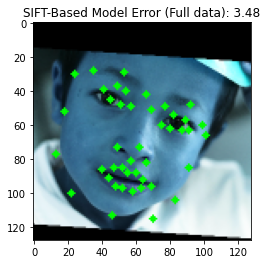

In [13]:
# print the results
print("Full dataset:")
print("Mean Euclidean distance:", mean_dist_full)
print("Standard deviation of Euclidean distance:", std_dist_full)
print("Mean error:", np.mean(errors_full))
sorted_errors_idx = np.argsort(errors_full)[-5:] # 5 worst predictions

#visualize
# full dataset
for idx in sorted_errors_idx:
    print(f"SIFT-Based Model Error (Full data): {distances_full[idx]}")
    visualise_pts(scaled_val_images_full[idx, ...], val_predicted_points_full[idx, ...], title=f"SIFT-Based Model Error (Full data): {distances_full[idx]:.2f}")
    plt.show()


Subset dataset:
Mean Euclidean distance: 3.854510139496818
Standard deviation of Euclidean distance: 2.5156304600820225
Mean error: 5357.769093900577
SIFT-Based Model Error (Subset data): 3.894454501976708


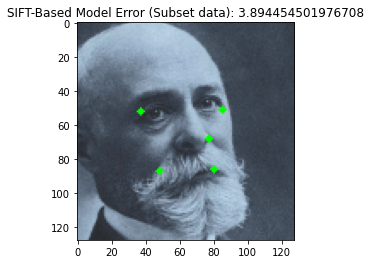

In [14]:
print("\nSubset dataset:")
print("Mean Euclidean distance:", mean_dist_subset)
print("Standard deviation of Euclidean distance:", std_dist_subset)
print("Mean error:", np.mean(errors_subset))
sorted_errors_idx_subset = np.argsort(errors_subset)[-5:] # 5 worst predictions

# subset dataset
for idx in sorted_errors_idx_subset:
    print(f"SIFT-Based Model Error (Subset data): {distances_subset[idx]}")
    visualise_pts(scaled_val_images_subset[idx, ...], val_predicted_points_subset[idx, ...], title= f"SIFT-Based Model Error (Subset data): {distances_subset[idx]}")

### 4.3 Alternative Face Recognition Model: HOG & ORB (Training and Performance Evaluation)

In [15]:
"""
Alternative feature extraction technique
- the HOG descriptor
- the ORB descriptor
"""
def extract_hog_features(image):
    hog_features, _ = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, multichannel=True)
    return hog_features

def extract_orb_features(image, num_keypoints=200, max_keypoints=100):
    orb = cv2.ORB_create(nfeatures=num_keypoints)
    keypoints, descriptors = orb.detectAndCompute(image, None)
    if descriptors is None:
        return np.zeros((max_keypoints * 32,))
    descriptors = descriptors[:max_keypoints, :]
    padded_descriptors = np.zeros((max_keypoints, 32))
    padded_descriptors[:descriptors.shape[0], :descriptors.shape[1]] = descriptors
    return padded_descriptors.flatten()

In [16]:
"""
Extract features using these alternative feature extraction techniques
"""

# Extract HOG features
train_features_full_hog = extract_features_from_images(train_images, extract_hog_features)
val_features_full_hog = extract_features_from_images(scaled_val_images_full, extract_hog_features)

# Train the HOG-based models
models_full_hog = train_linear_regression_models(train_features_full_hog, scaled_train_points)

In [17]:
# Extract ORB features
train_features_full_orb = extract_features_from_images(train_images, extract_orb_features)
val_features_full_orb = extract_features_from_images(scaled_val_images_full, extract_orb_features)

# Train the ORB-based models
models_full_orb = train_linear_regression_models(train_features_full_orb, scaled_train_points)

In [18]:
# Predict landmarks for the validation set using HOG and ORB models
val_predicted_points_full_hog = predict_landmarks(val_features_full_hog, models_full_hog)
val_predicted_points_full_orb = predict_landmarks(val_features_full_orb, models_full_orb)

# Calculate the Euclidean distances for the validation set
distances_full_hog = euclid_dist(val_predicted_points_full_hog, scaled_val_points_full)
distances_full_orb = euclid_dist(val_predicted_points_full_orb, scaled_val_points_full)

# Compute mean and standard deviation for both HOG and ORB-based models
mean_dist_full_hog = np.mean(distances_full_hog)
std_dist_full_hog = np.std(distances_full_hog)
errors_full_hog = np.sum(distances_full_hog)

mean_dist_full_orb = np.mean(distances_full_orb)
std_dist_full_orb = np.std(distances_full_orb)
errors_full_orb = np.sum(distances_full_orb)

HOG-based model:
Mean Euclidean distance: 4.641035378622149
Standard deviation of Euclidean distance: 3.280360730365906
Mean error: 58198.58364792175
HOG-based model Error: 7.909284148880195


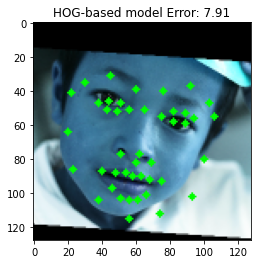

In [19]:
print("HOG-based model:")
print("Mean Euclidean distance:", mean_dist_full_hog)
print("Standard deviation of Euclidean distance:", std_dist_full_hog)
print("Mean error:", np.mean(errors_full_hog))
sorted_errors_idx_full_hog = np.argsort(errors_full_hog)[-5:] # 5 worst predictions

#visualize
# HOG-based model
for idx in sorted_errors_idx_full_hog:
    print(f"HOG-based model Error: {distances_full_hog[idx]}")
    visualise_pts(scaled_val_images_full[idx, ...], val_predicted_points_full_hog[idx, ...], title=f"HOG-based model Error: {distances_full_hog[idx]:.2f}")
    plt.show()


ORB-based model:
Mean Euclidean distance: 8.452315360615193
Standard deviation of Euclidean distance: 5.890852246002525
Mean error: 105992.03462211453
ORB-based model Error: 22.745211641015082


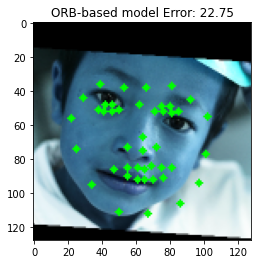

In [20]:
print("\nORB-based model:")
print("Mean Euclidean distance:", mean_dist_full_orb)
print("Standard deviation of Euclidean distance:", std_dist_full_orb)
print("Mean error:", np.mean(errors_full_orb))
sorted_errors_idx_full_orb = np.argsort(errors_full_orb)[-5:] # 5 worst predictions

# visualize
# ORB-based model
for idx in sorted_errors_idx_full_orb:
    print(f"ORB-based model Error: {distances_full_orb[idx]}")
    visualise_pts(scaled_val_images_full[idx, ...], val_predicted_points_full_orb[idx, ...], title=f"ORB-based model Error: {distances_full_orb[idx]:.2f}")
    plt.show()

## 5. Comparison

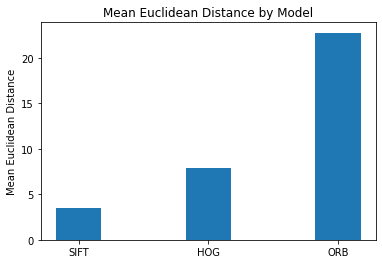

In [25]:
# comparison on the Euclidean distance between the three models
models = ['SIFT', 'HOG', 'ORB']
mean_euclidean_distances = [3.4828647872347527, 7.909284148880195, 22.745211641015082]

# Create bar plot
fig, ax = plt.subplots()
bar_width = 0.35
index = np.arange(len(models))

# Add bars to the plot
rects = ax.bar(index, mean_euclidean_distances, bar_width, label="Mean Euclidean Distance")

# Add labels, title and axes ticks
ax.set_ylabel("Mean Euclidean Distance")
ax.set_title("Mean Euclidean Distance by Model")
ax.set_xticks(index)
ax.set_xticklabels(models)

plt.show()


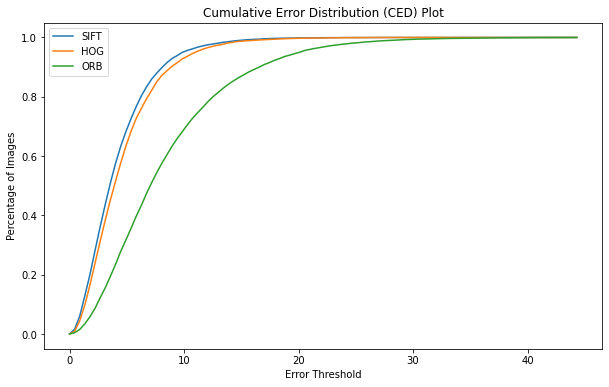

In [26]:
# CED plots
errors_sift = np.array(distances_full)
errors_hog = np.array(distances_full_hog)
errors_orb = np.array(distances_full_orb)

# Calculate CED
max_error = max(errors_sift.max(), errors_hog.max(), errors_orb.max())
thresholds = np.linspace(0, max_error, num=100)
ced_sift = np.array([np.sum(errors_sift <= thr) / len(errors_sift) for thr in thresholds])
ced_hog = np.array([np.sum(errors_hog <= thr) / len(errors_hog) for thr in thresholds])
ced_orb = np.array([np.sum(errors_orb <= thr) / len(errors_orb) for thr in thresholds])

# Create CED plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, ced_sift, label="SIFT")
plt.plot(thresholds, ced_hog, label="HOG")
plt.plot(thresholds, ced_orb, label="ORB")

plt.xlabel("Error Threshold")
plt.ylabel("Percentage of Images")
plt.title("Cumulative Error Distribution (CED) Plot")
plt.legend()

plt.show()

## 6. Conclusion

In [23]:
"""
The SIFT-Based Face Alignment Model performs the best, on the .
Thus, these results are the ones that are saved for the final submission.
predict the landmark coordinates for the test dataset
"""
test_predicted_points_full = predict_landmarks(test_features, models_full)
test_predicted_points_subset = predict_landmarks(test_features, models_subset)

In [24]:
"""
Save predicted landmark coordinates to a CSV file
this is for the best model: SIFT-Based model on the full dataset
"""
# Save the final predictions as a CSV file
save_as_csv(test_predicted_points_full)
